# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [23]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from scipy.stats import normaltest



The number of samples: 186
The number of columns: 493
The number of malignant samples: 94
The number of benign samples: 92


[Text(0.5, 1.0, 'Voorbeeld grafiek om te inspecteren hoe de data is verdeeld')]

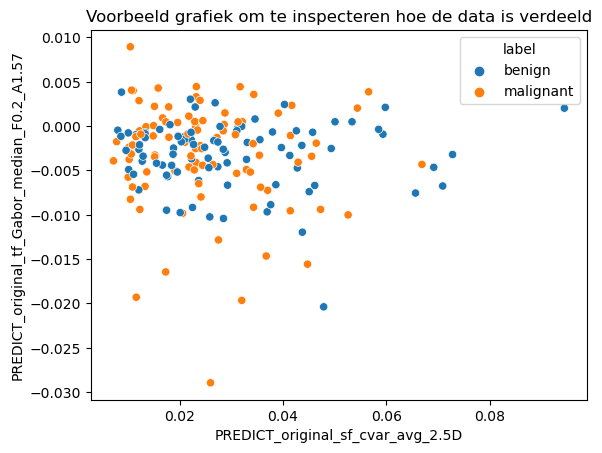

In [3]:
# Data loading functions. Uncomment the one you want to use
from worcliver.load_data import load_data

data = load_data()

# De label kolom even uit de dataset halen
X = data.drop('label', axis=1)   # drop the label category
y = data['label']                # Target variable die we proberen te voorspellen met het algoritme

# Make a list of feature names
feature_names = list(X.columns)

n_samples = len(data.index)
n_features = len(X.columns)
print(f'The number of samples: {n_samples}')
print(f'The number of columns: {n_features}')

n_malignant = len(y[y=='malignant'])
n_benign = len(y[y=='benign'])
print(f'The number of malignant samples: {n_malignant}')
print(f"The number of benign samples: {n_benign}")

sb.scatterplot(x =feature_names[8], y = feature_names[340], data=data, hue= "label").set(title="Voorbeeld grafiek om te inspecteren hoe de data is verdeeld")

### Deleting incomplete features and patients

In [4]:
nullen = X.eq(0.0).sum()
alle_nullen = sum(nullen)
print(f'Aantal nullen in de data: {alle_nullen}') 


patient0={}
for patients in X.index:
    zero_count1 = (X.loc[patients]==0.0).sum()
    patient0[patients]=zero_count1

print(f"Hoeveelheid nullen per patient: {patient0}")

features0={}
for features in X.columns:
    zero_count2 = (X[features]==0).sum()
    features0[features]=zero_count2

features0 = {feature: count for feature, count in features0.items() if count!=0} #om alle volledige rijen, met 0 zeros eruit te halen. Vooral voor overzicht voor onszelf. 

print(f"Hoeveelheid nullen per feature: {features0}")

cutoff_feature = 0.7*n_samples
#cutoff_sample = 0.9*n_features

X_drop = X[:]
Y_drop = y[:]

for feature, counts in features0.items():
    if counts >= cutoff_feature:
        X_drop = X_drop.drop(feature, axis=1)

# for patient, count in patient0.items():
#     if count >= cutoff_sample:
#         X_drop = X_drop.drop(patient, axis=0)
#         Y_drop = Y_drop.drop(patient, axis=0)
            
print(f"Dimesies dataframe na verwijderen unrelevant features {X_drop.shape}")



Aantal nullen in de data: 4341
Hoeveelheid nullen per patient: {'Liver-001_0': 25, 'Liver-002_0': 22, 'Liver-003_0': 22, 'Liver-004_0': 25, 'Liver-005_0': 22, 'Liver-006_0': 22, 'Liver-007_0': 25, 'Liver-008_0': 23, 'Liver-009_0': 25, 'Liver-010_0': 21, 'Liver-011_0': 25, 'Liver-012_0': 25, 'Liver-013_0': 24, 'Liver-014_0': 24, 'Liver-015_0': 23, 'Liver-016_0': 24, 'Liver-017_0': 22, 'Liver-018_0': 15, 'Liver-019_0': 22, 'Liver-020_0': 24, 'Liver-021_0': 22, 'Liver-022_0': 23, 'Liver-023_0': 25, 'Liver-024_0': 24, 'Liver-025_0': 27, 'Liver-026_0': 24, 'Liver-027_0': 24, 'Liver-028_0': 23, 'Liver-029_0': 23, 'Liver-030_0': 24, 'Liver-031_0': 24, 'Liver-032_0': 23, 'Liver-033_0': 24, 'Liver-034_0': 24, 'Liver-035_0': 23, 'Liver-036_0': 27, 'Liver-037_0': 24, 'Liver-038_0': 25, 'Liver-039_0': 24, 'Liver-040_0': 24, 'Liver-041_0': 18, 'Liver-042_0': 21, 'Liver-043_0': 26, 'Liver-044_0': 21, 'Liver-045_0': 24, 'Liver-046_0': 24, 'Liver-047_0': 25, 'Liver-048_0': 22, 'Liver-049_0': 25, 'Live

### Check normality

In [5]:
## Normality check
# P-waarde berekenen voor elke feature (statistiek test om te testen of H0: Data is normaal verdeeld)
p_values = []
for features in X_drop.columns:
    _, p = normaltest(X[features])
    p_values.append(p)

for i, features in enumerate(X_drop.columns):
    print("Variable:", features)
    print("p-value:", p_values[i])
    if p_values[i] < 0.05:
        print("The variable is not normally distributed")
    else:
        print("The variable is normally distributed")

c:\Users\meije\miniconda3\lib\site-packages\scipy\stats\_stats_py.py:1670: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
c:\Users\meije\miniconda3\lib\site-packages\scipy\stats\_stats_py.py:1774: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


Variable: PREDICT_original_sf_compactness_avg_2.5D
p-value: 1.145662534663526e-10
The variable is not normally distributed
Variable: PREDICT_original_sf_compactness_std_2.5D
p-value: 5.082112458342082e-16
The variable is not normally distributed
Variable: PREDICT_original_sf_rad_dist_avg_2.5D
p-value: 4.280298135711637e-06
The variable is not normally distributed
Variable: PREDICT_original_sf_rad_dist_std_2.5D
p-value: 2.4907255505070975e-14
The variable is not normally distributed
Variable: PREDICT_original_sf_roughness_avg_2.5D
p-value: 3.0991062140741755e-09
The variable is not normally distributed
Variable: PREDICT_original_sf_roughness_std_2.5D
p-value: 3.467791393271106e-23
The variable is not normally distributed
Variable: PREDICT_original_sf_convexity_avg_2.5D
p-value: 3.1390583766102673e-26
The variable is not normally distributed
Variable: PREDICT_original_sf_convexity_std_2.5D
p-value: 1.6120456237759444e-28
The variable is not normally distributed
Variable: PREDICT_original

## Splitting data into test and trainingset

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_drop, Y_drop, test_size=0.2, random_state=42)

print("Training set dimensies:", X_train.shape, y_train.shape)
print("Testing set dimensies:", X_test.shape, y_test.shape)


Training set dimensies: (148, 469) (148,)
Testing set dimensies: (38, 469) (38,)


VANAF HIER ALLEEN NOG MAAR DINGEN DOEN OP DE TRAININGSET!!

## Iets doen met de nullen die overbljiven

In [7]:
# Gemiddelde van elke feature berekenen (zonder meenemen 0.0)

# example = {'A': [1, 2, 3, 0],
#         'B': [4, 0, 6, 7],
#         'C': [0, 9, 10, 11],
#         'D': [12, 13, 14, 0]}
# exampledf = pd.DataFrame(example)

# feature_average={}
# print(exampledf)
# #print(X_train["PREDICT_original_sf_compactness_std_2.5D"].mean())

# exampleno0=exampledf[:]
# for feature in exampledf.columns:
#     feature_average[feature] = exampledf[feature][exampledf[feature] != 0.0].mean()
#     exampleno0[feature][exampleno0[feature]==0.0] = feature_average[feature]

# print(feature_average)
# print(exampleno0)


#print(X_no0["PREDICT_original_sf_compactness_std_2.5D"].mean())





## Scaling the data

C:\Users\meije\AppData\Local\Temp\ipykernel_18296\2595168876.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_norm['label'] = y_train.values


[Text(0.5, 1.0, 'Voorbeeld grafiek om te inspecteren hoe de data is verdeeld na schalen')]

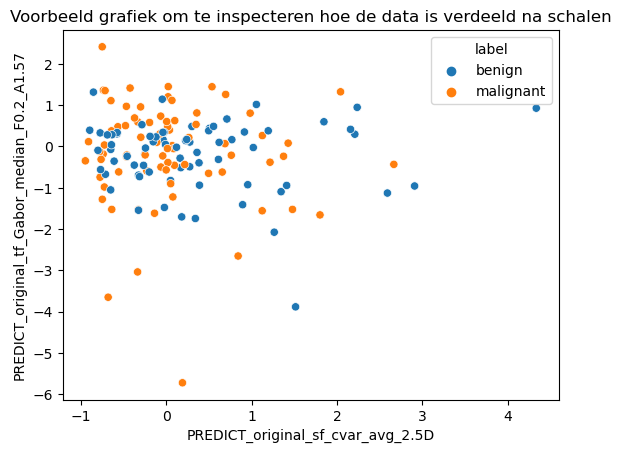

In [8]:
scaler = RobustScaler().fit(X_train) #Dit schaalt de data
X_train_normalized = scaler.transform(X_train)

#X_test_normalized = Schaler.transform(X_test)
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns) #de normalized functie zorgt voor een numpy array, dus moet weer even teruggezet worden in een dataframe. 
#X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

# Plotten om te zien hoe het er nu uitziet: 
X_train_norm = X_train_normalized[:]
X_train_norm['label'] = y_train.values
sb.scatterplot(data=X_train_norm, x=feature_names[8], y=feature_names[340], hue='label').set(title="Voorbeeld grafiek om te inspecteren hoe de data is verdeeld na schalen")


## Feature selection

In [17]:
# Feature selection using logistic regression
logistic = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=7).fit(X_train_normalized,y_train)

model = SelectFromModel(logistic, prefit=True)
#X_train_selected = model.transform(X_train_normalized)

SF = model.get_support()
X_train_features = X_train_normalized.loc[:,SF]

## Classifier

Random forest score:0.7496551724137931


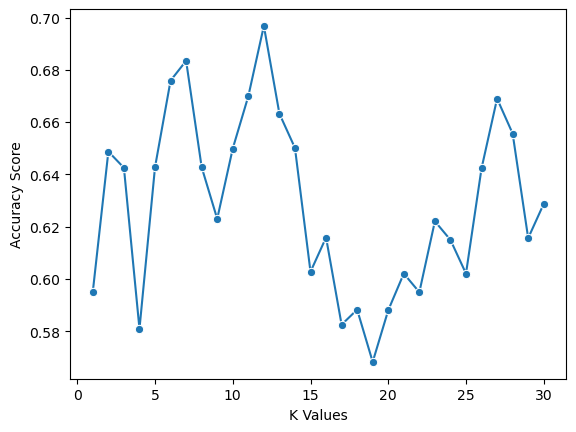

In [25]:
# KNN classifier

k_values = [i for i in range (1,31)]
scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_features, y_train, cv=5)
    scores.append(np.mean(score))

sb.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

# Random forest 

n_value = 100
random_forest = RandomForestClassifier(n_estimators=n_value)
random_forest.fit(X_train, y_train)
score = cross_val_score(random_forest, X_train_features, y_train, cv=5)
print(f'Random forest score:{np.mean(score)}')


## Pipeline

In [26]:
# Een voorbeeld van het gebruiken van een pipeline waarbij je meerdere parameters kan testen/optimaliseren

pipe = Pipeline([
('scaler', RobustScaler()),
('selector', VarianceThreshold()),
('classifier', KNeighborsClassifier())
])

parameters = {'scaler': [RobustScaler(), MinMaxScaler()],
 'selector__threshold': [0, 0.001, 0.01],
 'classifier__n_neighbors': [1, 3, 5, 7, 10],
 'classifier__p': [1, 2],
 'classifier__leaf_size': [1, 5, 10, 15]
}

# Grid search waarbij je de optimale parameters gaat zoeken

grid = GridSearchCV(pipe, parameters, cv=2).fit(X_train, y_train)
print('Training set score: ' + str(grid.score(X_train, y_train)))

best_pipe = grid.best_estimator_
print(best_pipe)

Training set score: 1.0
Pipeline(steps=[('scaler', RobustScaler()),
                ('selector', VarianceThreshold(threshold=0)),
                ('classifier',
                 KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1))])
